# Mushroom Classification Project 🍄

## Introduction

In US alone, around 7500 yearly cases of mushrooms poisoning are reported [Source](https://www.tandfonline.com/doi/abs/10.1080/00275514.2018.1479561). According to the source, "misidentification of edible mushroom species appears to be the most common cause and may be preventable through education".

In the dataset there are 9 folders of images of most common **Northern European mushrooms genuses**. Each folder consist of from 300 to 1500 selected images of mushrooms genuses.

Our task in this notebook is to create a model that is capable of identifying these different classes.

##  Imports

In [ ]:
import torch
from torch import nn
from torchvision import models
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchvision.models import ResNet18_Weights, ResNet152_Weights
from torchvision.transforms import functional as F

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import lightning as pl
from lightning import Trainer
from lightning.pytorch.callbacks import LearningRateMonitor

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import os
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Basic Exploration

In [ ]:
data_dir = '/content/Mushrooms'

basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize all images to 224x224
    transforms.ToTensor(),
])

# Load the dataset with basic transform
dataset_basic = datasets.ImageFolder(data_dir, transform=basic_transform)

In [ ]:
# Calculate mean and std on the training portion of the dataset
def calculate_mean_std(dataset, batch_size=64):
    # Create a DataLoader with the dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize variables to store the sum of means and stds
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_batches = 0

    # Iterate through the DataLoader
    for batch in dataloader:
        images, _ = batch

        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_batches += batch_samples

    # Calculate the mean and std
    mean /= total_batches
    std /= total_batches

    return mean, std

In [ ]:
mean, std = calculate_mean_std(dataset_basic)
print(f"Mean: {mean}, Std: {std}")

Mean: tensor([0.3914, 0.3697, 0.2815]), Std: tensor([0.2291, 0.2094, 0.2031])


In [ ]:
num_classes = len(dataset_basic.classes)
print('Number of classes:', num_classes)

Number of classes: 9


In the dataset we have 9 mushroom classes. The name for each class is listed below.

In [ ]:
print('Class names:', dataset_basic.classes)

Class names: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


These are the 9 different classes of Mushroom that we have in our dataset.

Below is a very short description about the different genuses.

**Agaricus**: This genus includes the common mushroom, which is
widely cultivated and consumed around the world. It is also found in the wild and can be identified by its white cap and pink gills. Some species of Agaricus are edible, while others are poisonous.

**Amanita**: This genus includes some of the most toxic mushrooms known to man, such as the death cap and destroying angel. They are characterized by their distinctive cup-shaped volva at the base of the stem and their white spores. Some species of Amanita are edible, but they must be prepared carefully to avoid poisoning.

**Boletus**: This genus includes several edible species, such as the cep or porcini mushroom, which is highly prized for its rich flavor and meaty texture. Boletus mushrooms have a distinctive cap that is often brown or reddish-brown in color and a porous underside instead of gills.

**Cortinarius**: This genus includes many species that are difficult to identify and some that are poisonous. They are characterized by their rusty brown spores and the remnants of a veil that covers the stem when young. Some species of Cortinarius are edible, but many are not recommended for consumption.

**Entoloma**: This genus includes many species that are difficult to identify and some that are poisonous. They are characterized by their pink or lilac spores and their gills that are attached to the stem instead of running down it. Some species of Entoloma are edible, but many are not recommended for consumption.

**Hygrocybe**: This genus includes many species that are brightly colored and often found in grassy areas or mossy woods. They are characterized by their waxy caps and their gills that are usually brightly colored as well. Some species of Hygrocybe are edible, but many have not been tested for toxicity.

**Lactarius**: This genus includes many species that exude a milky substance when cut or broken. They are characterized by their gills that often have a decurrent attachment to the stem and their white spores. Some species of Lactarius are edible, but others can cause gastrointestinal distress.

**Russula**: This genus includes many species that have brightly colored caps and white spores. They are characterized by their brittle flesh and their gills that do not run down the stem. Some species of Russula are edible, but others can cause gastrointestinal distress.

**Suillus**: This genus includes several edible species, such as the slippery jack mushroom, which is often found in coniferous forests. Suillus mushrooms have a distinctive slimy cap and pores instead of gills.

[Source](https://johnbeaufoy.com/identification-guide-to-mushrooms-of-britain-and-northern-europe/)

The most edible Mushroom genuses are Agaricus, Boletus, and Suillus with some mostly cultivated of their genuses respectively being
**Agaricus bisporus**: This is the most commonly cultivated and consumed mushroom in North America and Europe. It is an edible basidiomycete mushroom that is native to grasslands in Europe and North America.
**Boletus edulis**: Also known as the cep or porcini mushroom, this is a highly prized edible mushroom that has a rich flavor and meaty texture. It is often used in soups, stews, and risottos2.
**Suillus luteus**: This is a common edible mushroom that is often found in coniferous forests. It has a slimy cap and pores instead of gills3.

[Source](https://www.nutritionadvance.com/types-of-edible-mushrooms/)

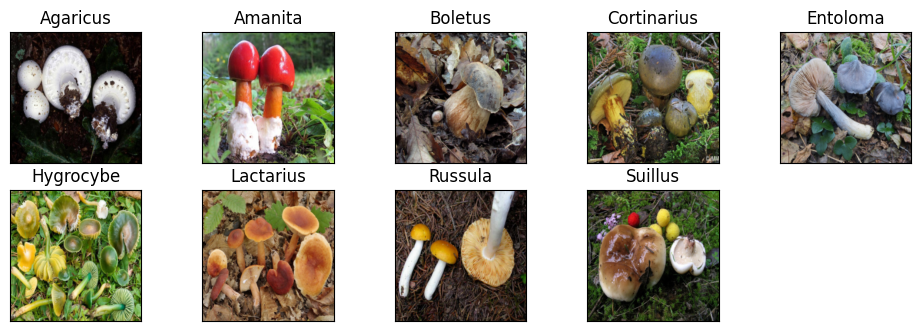

In [ ]:
fig = plt.figure(figsize=(12, 14))
for i in range(num_classes):
    ax = fig.add_subplot(7, 5, i + 1, xticks=[], yticks=[])
    idx = dataset_basic.targets.index(i)
    img = dataset_basic[idx][0]
    ax.set_title(dataset_basic.classes[i])
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
df = pd.DataFrame(dataset_basic.targets, columns=['class'])
df['class_name'] = df['class'].apply(lambda x: dataset_basic.classes[x])

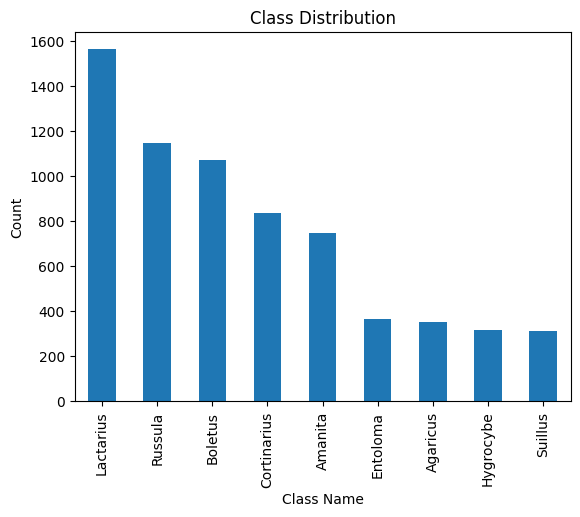

In [ ]:
class_counts = df['class_name'].value_counts()

class_counts.plot(kind='bar')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

Looking at the number of data points we have for each class we notice an imbalance in the dataset.

## Modelling

In [ ]:
original_dataset = dataset_basic

# First split the original dataset to prevent data leakage
train_size = int(0.7 * len(original_dataset))
val_size = int(0.15 * len(original_dataset))
test_size = len(original_dataset) - train_size - val_size

generator = torch.Generator().manual_seed(42)

# Use stratified sampling to ensure class distribution is maintained
y = torch.tensor([label for _, label in original_dataset])

from sklearn.model_selection import train_test_split

train_indices, temp_indices = train_test_split(
    range(len(original_dataset)),
    test_size=(val_size + test_size) / len(original_dataset),
    random_state=42,
    stratify=y
)

val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=test_size / (val_size + test_size),
    random_state=42,
    stratify=y[temp_indices]
)

# Create subset datasets
from torch.utils.data import Subset
train_dataset_orig = Subset(original_dataset, train_indices)
val_dataset = Subset(original_dataset, val_indices)
test_dataset = Subset(original_dataset, test_indices)

In [ ]:
class ImprovedAugmentedDataset(Dataset):
    def __init__(self, original_dataset, augmentation_factor_per_class=None, default_factor=1):
        self.original_dataset = original_dataset

        # Count samples per class
        class_counts = {}
        for idx in range(len(original_dataset)):
            _, label = original_dataset[idx]
            if label not in class_counts:
                class_counts[label] = 0
            class_counts[label] += 1

        # Determine target count (use the max class count)
        self.max_count = max(class_counts.values())

        # Calculate augmentation factors if not provided
        if augmentation_factor_per_class is None:
            self.augmentation_factors = {}
            for label, count in class_counts.items():
                # Calculate how many times we need to augment each sample
                # to reach approximately the max_count
                factor = max(1, int(self.max_count / count))
                self.augmentation_factors[label] = min(factor, 10)  # Cap at 10 to prevent excessive augmentation
        else:
            self.augmentation_factors = augmentation_factor_per_class

        # Create a mapping of original indices to use for augmentation
        self.augmentation_indices = []
        for idx in range(len(original_dataset)):
            _, label = original_dataset[idx]
            # Add this index multiple times based on its augmentation factor
            for _ in range(self.augmentation_factors.get(label, default_factor)):
                self.augmentation_indices.append(idx)

        # Print augmentation statistics
        print(f"Augmentation factors: {self.augmentation_factors}")
        print(f"Total samples after augmentation: {len(self.augmentation_indices)}")

        # Define advanced augmentation transforms
        self.color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
        self.gaussian_blur = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))

    def __len__(self):
        return len(self.augmentation_indices)

    def __getitem__(self, index):
        original_index = self.augmentation_indices[index]
        image, label = self.original_dataset[original_index]

        # Apply random augmentations with probability
        # Spatial transforms
        if random.random() < 0.5:
            image = F.hflip(image)
        if random.random() < 0.3:  # Less likely for vertical flip
            image = F.vflip(image)

        # Random rotation
        angle = random.uniform(-30, 30)
        image = F.rotate(image, angle)

        # Random perspective distortion (subtle)
        if random.random() < 0.3:
            # Get image dimensions - using the tensor shape instead of _get_image_size
            height, width = image.shape[1], image.shape[2]  # For tensor [C, H, W]
            startpoints, endpoints = transforms.RandomPerspective.get_params(width, height, 0.2)
            image = F.perspective(image, startpoints, endpoints)

        # Color transforms
        if random.random() < 0.5:
            image = self.color_jitter(image)

        # Occasional blur (mushrooms can be blurry in photos)
        if random.random() < 0.2:
            image = self.gaussian_blur(image)

        # Random crop and resize (simulates different zoom levels)
        if random.random() < 0.3:
            # Get image dimensions
            height, width = image.shape[1], image.shape[2]  # For tensor [C, H, W]
            i, j, h, w = transforms.RandomResizedCrop.get_params(
                image, scale=(0.7, 1.0), ratio=(0.9, 1.1))
            # Use the size tuple directly
            image = F.resized_crop(image, i, j, h, w, (height, width))

        return image, label


train_dataset_augmented = ImprovedAugmentedDataset(train_dataset_orig)

Augmentation factors: {3: 1, 6: 1, 2: 1, 7: 1, 4: 4, 5: 4, 8: 5, 1: 2, 0: 4}
Total samples after augmentation: 8265


In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2)

# Calculate class weights based on the original dataset distribution
class_counts = {}
for _, label in original_dataset:
    if label not in class_counts:
        class_counts[label] = 0
    class_counts[label] += 1

num_classes = len(class_counts)
total_samples = len(original_dataset)

# Calculate inverse frequency weights
class_weights = []
for i in range(num_classes):
    weight = total_samples / (num_classes * class_counts.get(i, 1))
    class_weights.append(weight)

class_weights_tensor = torch.tensor(class_weights).float()
if torch.cuda.is_available():
    class_weights_tensor = class_weights_tensor.cuda()

print("Class weights:", class_weights_tensor)

Class weights: tensor([2.1133, 0.9947, 0.6952, 0.8923, 2.0495, 2.3608, 0.4773, 0.6498, 2.3987],
       device='cuda:0')


In [ ]:
class MushroomClassifierI(pl.LightningModule):
    def __init__(self, num_classes: int, class_weights, unfreeze_strategy='partial'):
        super().__init__()
        self.model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
        self.class_weights = class_weights
        self.outputs = []
        self.train_losses = []
        self.val_losses = []
        self._epoch_counter = 0
        self.unfreeze_strategy = unfreeze_strategy

        # Apply the initial freezing strategy
        self._apply_freeze_strategy()

    def _apply_freeze_strategy(self):
        # First freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False

        if self.unfreeze_strategy == 'none':
            # Keep everything frozen except the final layer
            for param in self.model.fc.parameters():
                param.requires_grad = True

        elif self.unfreeze_strategy == 'partial':
            # Unfreeze the last layer and the last block of ResNet
            for param in self.model.fc.parameters():
                param.requires_grad = True
            for param in self.model.layer4.parameters():  # Last ResNet block
                param.requires_grad = True

        elif self.unfreeze_strategy == 'full':
            # Unfreeze the entire model
            for param in self.model.parameters():
                param.requires_grad = True

        elif self.unfreeze_strategy == 'progressive':
            # Start with just the last layer unfrozen
            # The rest will be unfrozen progressively during training
            for param in self.model.fc.parameters():
                param.requires_grad = True

    def on_train_epoch_start(self):
        # Progressive unfreezing based on epoch number
        if self.unfreeze_strategy == 'progressive':
            if self._epoch_counter == 5:  # After 5 epochs, unfreeze layer4
                print("Unfreezing layer4 (epoch 5)")
                for param in self.model.layer4.parameters():
                    param.requires_grad = True
            elif self._epoch_counter == 10:  # After 10 epochs, unfreeze layer3
                print("Unfreezing layer3 (epoch 10)")
                for param in self.model.layer3.parameters():
                    param.requires_grad = True
            elif self._epoch_counter == 15:  # After 15 epochs, unfreeze layer2
                print("Unfreezing layer2 (epoch 15)")
                for param in self.model.layer2.parameters():
                    param.requires_grad = True

    def forward(self, x):
        return self.model(x)


    def training_step(self, batch, batch_idx):
        x, y = batch
        start_time = time.time()
        logits = self(x)
        end_time = time.time()
        inference_time = end_time - start_time
        self.log('inference_time_train', inference_time, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        loss = nn.CrossEntropyLoss(weight=self.class_weights)(logits, y)
        return loss


    def on_train_epoch_end(self) -> None:
        self.train_losses.append(self.trainer.callback_metrics['train_loss'].item())
        self.log('train_loss', self.train_losses[-1], on_epoch=True, prog_bar=True, logger=True)
        self._epoch_counter += 1


    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        self.outputs.append({'preds': preds, 'y': y})
        return {'preds': preds, 'y': y}

    def on_test_epoch_end(self):
        preds = torch.cat([out['preds'] for out in self.outputs])
        y = torch.cat([out['y'] for out in self.outputs])
        accuracy = accuracy_score(y.cpu(), preds.cpu())
        precision = precision_score(y.cpu(), preds.cpu(), average='macro')
        recall = recall_score(y.cpu(), preds.cpu(), average='macro')
        f1 = f1_score(y.cpu(), preds.cpu(), average='macro')
        self.log('test_accuracy', accuracy, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_precision', precision, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_recall', recall, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_f1', f1, on_epoch=True, prog_bar=True, logger=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        start_time = time.time()
        logits = self(x)
        end_time = time.time()
        inference_time = end_time - start_time
        self.log('inference_time', inference_time, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        loss = nn.CrossEntropyLoss(weight=self.class_weights)(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self) -> None:
        self.val_losses.append(self.trainer.callback_metrics['val_loss'].item())
        self.log('val_loss', self.val_losses[-1], on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        # Use different learning rates for different parts of the network
        # This is especially important when using progressive unfreezing

        # Group parameters by layers for different learning rates
        if self.unfreeze_strategy == 'progressive' or self.unfreeze_strategy == 'partial':
            # Higher learning rate for newly added layers, lower for pretrained layers
            params = [
                {'params': self.model.fc.parameters(), 'lr': 1e-3},  # Higher LR for the new classification layer
            ]

            # Add unfrozen backbone layers with lower learning rate
            if any(p.requires_grad for p in self.model.layer4.parameters()):
                params.append({'params': self.model.layer4.parameters(), 'lr': 5e-4})
            if any(p.requires_grad for p in self.model.layer3.parameters()):
                params.append({'params': self.model.layer3.parameters(), 'lr': 1e-4})
            if any(p.requires_grad for p in self.model.layer2.parameters()):
                params.append({'params': self.model.layer2.parameters(), 'lr': 5e-5})
            if any(p.requires_grad for p in self.model.layer1.parameters()):
                params.append({'params': self.model.layer1.parameters(), 'lr': 1e-5})

            optimizer = torch.optim.AdamW(params, weight_decay=0.01)
        else:
            # Simple optimizer for full or none strategies
            optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3, weight_decay=0.01)

        # Use cosine annealing scheduler with warm restarts for better convergence
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer,
                T_0=5,  # Restart every 5 epochs
                T_mult=2,  # Double the restart interval after each restart
                eta_min=1e-6  # Minimum learning rate
            ),
            'interval': 'epoch',
            'frequency': 1,
            'name': 'cosine_lr'
        }

        return [optimizer], [lr_scheduler]

In [ ]:
model = MushroomClassifierI(num_classes, class_weights_tensor, unfreeze_strategy='progressive')

In [ ]:
lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [ ]:
from lightning.pytorch.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

trainer = Trainer(
    max_epochs=30,
    callbacks=[lr_monitor, early_stopping],
    log_every_n_steps=10
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

In [ ]:
trainer.validate(model, val_loader)

In [ ]:
trainer.test(model, test_loader)

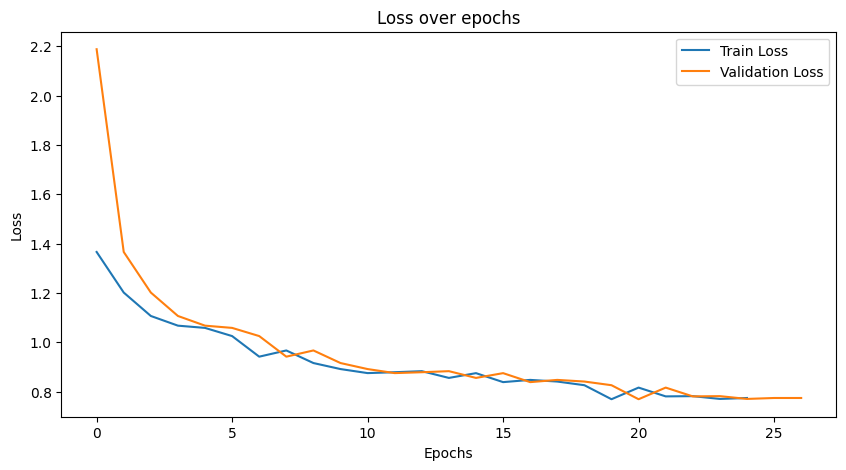

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(model.train_losses, label='Train Loss')
plt.plot(model.val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Our loss has bumped up around epoch 7 but has managed to decrease eventually.

In [ ]:
log_dir = './lightning_logs/version_1'
def get_all_logs(log_dir):
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    tags = event_acc.Tags()['scalars']

    logs = {}
    for tag in tags:
        logs[tag] = [s.value for s in event_acc.Scalars(tag)]

    return logs

all = get_all_logs(log_dir)

In [ ]:
all.keys()

dict_keys(['cosine_lr', 'inference_time_train_step', 'epoch', 'inference_time_step', 'train_loss_step', 'val_loss_step', 'inference_time_epoch', 'train_loss_epoch', 'val_loss_epoch', 'val_loss', 'inference_time_train_epoch', 'train_loss', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1'])

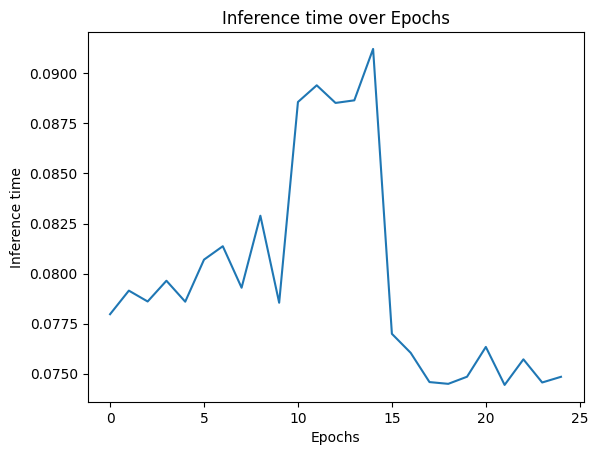

In [ ]:
plt.plot(all['inference_time_train_epoch'])
plt.xlabel('Epochs')
plt.ylabel('Inference time')
plt.title('Inference time over Epochs')
plt.show()

The inference time looks more synonymous to the previous one.

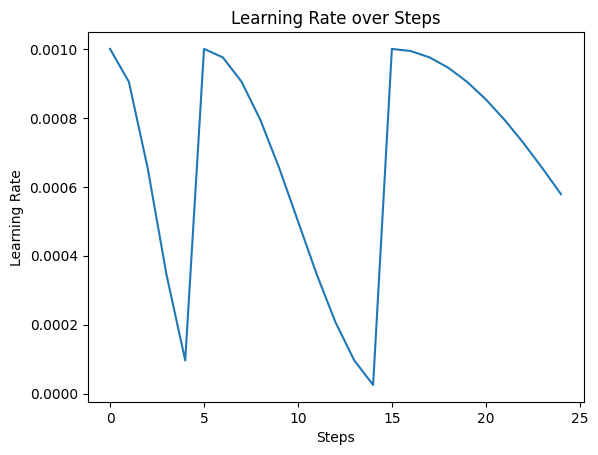

In [ ]:
lr_values = all['cosine_lr']
plt.plot(lr_values)
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Steps')
plt.show()

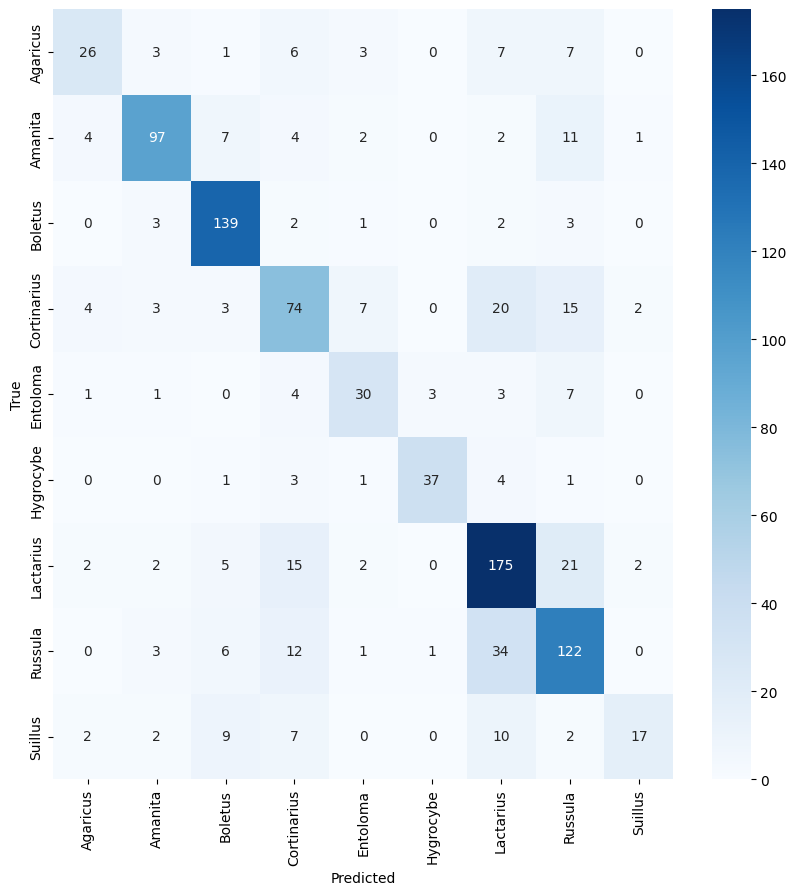

In [ ]:
true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to()
        labels = labels.to()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        true_labels.append(labels.cpu().numpy())
        pred_labels.append(preds.cpu().numpy())

true_labels = np.concatenate(true_labels)
pred_labels = np.concatenate(pred_labels)

cm = confusion_matrix(true_labels, pred_labels)

class_names = dataset_basic.classes

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
class MushroomClassifierEfficientNet(pl.LightningModule):
    def __init__(self, num_classes: int, class_weights, unfreeze_strategy='progressive',
                 efficientnet_version='b0', dropout_rate=0.3):
        super().__init__()

        # Load the selected EfficientNet model
        if efficientnet_version == 'b0':
            self.backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
            feature_dim = 1280
        elif efficientnet_version == 'b1':
            self.backbone = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
            feature_dim = 1280
        elif efficientnet_version == 'b2':
            self.backbone = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
            feature_dim = 1408
        elif efficientnet_version == 'b3':
            self.backbone = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
            feature_dim = 1536
        elif efficientnet_version == 'b4':
            self.backbone = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT)
            feature_dim = 1792
        else:
            raise ValueError(f"Unsupported EfficientNet version: {efficientnet_version}")

        # Remove the original classifier
        self.backbone.classifier = nn.Identity()

        # Add a spatial attention mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(feature_dim, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )

        # Add a new classifier with dropout
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

        self.class_weights = class_weights
        self.outputs = []
        self.train_losses = []
        self.val_losses = []
        self._epoch_counter = 0
        self.unfreeze_strategy = unfreeze_strategy
        self.efficientnet_version = efficientnet_version
        self.feature_dim = feature_dim

        # Apply the initial freezing strategy
        self._apply_freeze_strategy()

    def _apply_freeze_strategy(self):
        # First freeze all layers
        for param in self.backbone.parameters():
            param.requires_grad = False

        if self.unfreeze_strategy == 'none':
            # Keep everything frozen except the classifier
            for param in self.classifier.parameters():
                param.requires_grad = True
            for param in self.attention.parameters():
                param.requires_grad = True

        elif self.unfreeze_strategy == 'partial':
            # Unfreeze the classifier, attention, and the last block of EfficientNet
            for param in self.classifier.parameters():
                param.requires_grad = True
            for param in self.attention.parameters():
                param.requires_grad = True
            # Unfreeze the last convolutional block
            for param in self.backbone.features[-1].parameters():
                param.requires_grad = True

        elif self.unfreeze_strategy == 'full':
            # Unfreeze the entire model
            for param in self.backbone.parameters():
                param.requires_grad = True

        elif self.unfreeze_strategy == 'progressive':
            # Start with just the classifier and attention unfrozen
            # The rest will be unfrozen progressively during training
            for param in self.classifier.parameters():
                param.requires_grad = True
            for param in self.attention.parameters():
                param.requires_grad = True

    def on_train_epoch_start(self):
        # Progressive unfreezing based on epoch number
        if self.unfreeze_strategy == 'progressive':
            # EfficientNet has 8 blocks (0-7), we'll unfreeze from the end
            if self._epoch_counter == 5:  # After 5 epochs, unfreeze the last block
                print(f"Unfreezing last block (epoch {self._epoch_counter})")
                for param in self.backbone.features[-1].parameters():
                    param.requires_grad = True
            elif self._epoch_counter == 10:  # After 10 epochs, unfreeze the second last block
                print(f"Unfreezing second last block (epoch {self._epoch_counter})")
                for param in self.backbone.features[-2].parameters():
                    param.requires_grad = True
            elif self._epoch_counter == 15:  # After 15 epochs, unfreeze the third last block
                print(f"Unfreezing third last block (epoch {self._epoch_counter})")
                for param in self.backbone.features[-3].parameters():
                    param.requires_grad = True

    def forward(self, x):
        # Extract features from the backbone
        features = self.backbone.features(x)

        # Apply attention mechanism
        attention_map = self.attention(features)
        attended_features = features * attention_map

        # Pass through the classifier
        return self.classifier(attended_features)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y, weight=self.class_weights.to(self.device))
        preds = torch.argmax(logits, dim=1)
        acc = accuracy_score(preds, y, task="multiclass", num_classes=len(self.class_weights))
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y, weight=self.class_weights.to(self.device))
        preds = torch.argmax(logits, dim=1)
        acc = accuracy_score(preds, y, task="multiclass", num_classes=len(self.class_weights))
        precision_val = precision_score(preds, y, task="multiclass", num_classes=len(self.class_weights), average='macro')
        recall_val = recall_score(preds, y, task="multiclass", num_classes=len(self.class_weights), average='macro')
        f1_val = f1_score(preds, y, task="multiclass", num_classes=len(self.class_weights), average='macro')

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_precision', precision_val, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_recall', recall_val, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_f1', f1_val, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return {"val_loss": loss, "val_acc": acc}

    def on_validation_epoch_end(self) -> None:
        self.val_losses.append(self.trainer.callback_metrics['val_loss'].item())
        self.log('val_loss', self.val_losses[-1], on_epoch=True, prog_bar=True, logger=True)

    def on_train_epoch_end(self) -> None:
        self.train_losses.append(self.trainer.callback_metrics['train_loss'].item())
        self.log('train_loss', self.train_losses[-1], on_epoch=True, prog_bar=True, logger=True)
        self._epoch_counter += 1

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy_score(preds, y, task="multiclass", num_classes=len(self.class_weights))
        precision_val = precision_score(preds, y, task="multiclass", num_classes=len(self.class_weights), average='macro')
        recall_val = recall_score(preds, y, task="multiclass", num_classes=len(self.class_weights), average='macro')
        f1_val = f1_score(preds, y, task="multiclass", num_classes=len(self.class_weights), average='macro')

        self.log('test_accuracy', acc)
        self.log('test_precision', precision_val)
        self.log('test_recall', recall_val)
        self.log('test_f1', f1_val)

        return {"test_accuracy": acc, "test_precision": precision_val, "test_recall": recall_val, "test_f1": f1_val}

    def configure_optimizers(self):
        # Group parameters by learning rate
        # 1. Newly added layers (classifier and attention) - higher learning rate
        new_params = list(self.classifier.parameters()) + list(self.attention.parameters())

        # 2. Backbone layers - lower learning rate based on depth
        backbone_params = []
        if self.unfreeze_strategy in ['partial', 'full', 'progressive']:
            backbone_params = [p for p in self.backbone.parameters() if p.requires_grad]

        # Create parameter groups with different learning rates
        param_groups = [
            {'params': new_params, 'lr': 1e-3},
            {'params': backbone_params, 'lr': 1e-5}  # Much lower LR for pretrained backbone
        ]

        # Use AdamW optimizer with weight decay
        optimizer = torch.optim.AdamW(param_groups, weight_decay=1e-4)

        # Use cosine annealing with warm restarts
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=10,  # Restart every 10 epochs
            T_mult=1,  # Double the restart interval after each restart
            eta_min=1e-6  # Minimum learning rate
        )

        return [optimizer], [scheduler]


In [ ]:
def train_efficientnet_model(num_classes, class_weights, efficientnet_version='b0', unfreeze_strategy='progressive'):
    # Create the model
    model = MushroomClassifierEfficientNet(
        num_classes=num_classes,
        class_weights=class_weights,
        efficientnet_version=efficientnet_version,
        unfreeze_strategy=unfreeze_strategy,
        dropout_rate=0.3
    )

    # Create callbacks
    checkpoint_callback = ModelCheckpoint(
        monitor='val_f1',
        dirpath='./checkpoints/',
        filename='efficientnet-{epoch:02d}-{val_f1:.2f}',
        save_top_k=3,
        mode='max'
    )

    early_stop_callback = EarlyStopping(
        monitor='val_f1',
        min_delta=0.00,
        patience=10,
        verbose=True,
        mode='max'
    )

    # Create trainer
    trainer = pl.Trainer(
        max_epochs=50,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback, early_stop_callback],
        precision='16-mixed' if torch.cuda.is_available() else '32'  # Use mixed precision for faster training
    )

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Test the model
    results = trainer.test(model, test_loader)

    return model, results